In [2]:
%config InlineBackend.figure_format = 'retina'

# 代码自动完成提示 tab 键
%config IPCompleter.greedy=True

# 一个 cell 可以多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [ ]:
# 1. 生存曲线（累积值），全集，按某个维度细分(categorical)
# 2. 生存函数曲线（类似于 pdf），全集，按某个维度细分(categorical)
# 3. cox propotional model，多元回归，可以是 categorical，也可以是 numerical，
# 4. cox 在某一维度下的，不同 level 之间的生存曲线（累计值）的相对关系，以及与 baseline 的相对关系

In [4]:
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# https://github.com/threecifanggen/lambda-and-tau/blob/master/%E7%94%9F%E5%AD%98%E5%88%86%E6%9E%90-%E4%B8%80%E4%B8%AA%E5%AE%9E%E4%BE%8B/%E6%96%B0%E7%94%A8%E6%88%B7%E8%A1%8C%E4%B8%BA%E4%B8%8E%E7%94%9F%E5%AD%98%E5%88%86%E6%9E%90.md

In [6]:
df = pd.read_excel('./data/user_buy.xlsx')
df.head()

,seq,user_id,signup_time,end_time,test_last_time,buy_time,sex,birth_year,province,have_bought
0,0,513336,2017-10-30 21:58:04.323,2017-10-30 22:03:54.430,2018-06-01,2017-10-30 22:03:54.430,女,1991.0,山东,True
1,1,513340,2017-10-30 22:14:35.853,2017-10-30 22:45:10.243,2018-06-01,2017-10-30 22:45:10.243,男,1988.0,安徽,True
2,2,513353,2017-10-31 07:29:04.293,2018-06-01 00:00:00.000,2018-06-01,NaT,NaN,NaN,NaN,False
3,3,513370,2017-10-31 10:45:45.586,2018-06-01 00:00:00.000,2018-06-01,NaT,女,1979.0,河南,False
4,4,513387,2017-10-31 13:00:32.360,2017-10-31 13:09:38.100,2018-06-01,2017-10-31 13:09:38.100,女,1992.0,山东,True


In [7]:
# 查看数据的基本信息
df.describe(include='all')

,seq,user_id,signup_time,end_time,test_last_time,buy_time,sex,birth_year,province,have_bought
count,26563.000000,26563.000000,26563,26563,26563,11659,15217,13923.000000,15217,26563
unique,NaN,NaN,26563,11660,1,11659,2,NaN,31,2
top,NaN,NaN,2017-10-31 14:56:11.993000,2018-06-01 00:00:00,2018-06-01 00:00:00,2017-10-10 08:16:44.393000,女,NaN,浙江,False
freq,NaN,NaN,1,14904,26563,1,9691,NaN,1921,14904
first,NaN,NaN,2017-09-01 01:11:12.703000,2017-09-01 03:39:32.656000,2018-06-01 00:00:00,2017-09-01 03:39:32.656000,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-05-31 23:43:44.243000,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-05-31 23:56:19.263000,NaN,NaN,NaN,NaN
mean,13281.000000,519948.924820,NaN,NaN,NaN,NaN,NaN,1982.964950,NaN,NaN
std,7668.221936,7668.342368,NaN,NaN,NaN,NaN,NaN,11.346981,NaN,NaN
min,0.000000,506667.000000,NaN,NaN,NaN,NaN,NaN,1931.000000,NaN,NaN
25%,6640.500000,513308.500000,NaN,NaN,NaN,NaN,NaN,1976.000000,NaN,NaN


In [8]:
# 增加一列， seconds --> days
df['duration'] = (df['end_time'] - df['signup_time']).apply(lambda x: x.total_seconds()/3600/24)

<lifelines.KaplanMeierFitter: fitted with 26563 observations, 14904 censored>

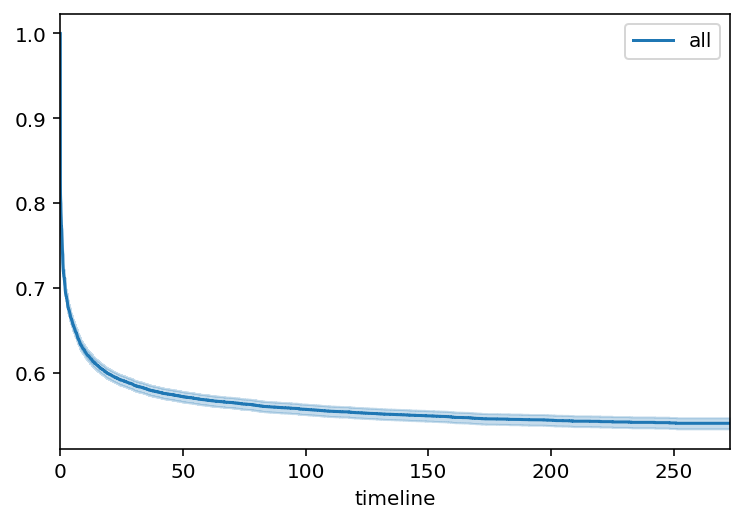

In [9]:
# KM 生存曲线，使用全部数据
# 这里没有对 have_bought 做处理，也即：里面有大量的 NaN
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['have_bought'], label='all')
kmf.plot()

# 从图中可看出，前 50 天变化明显，所以只关注前 50 天；

<lifelines.KaplanMeierFitter: fitted with 26563 observations, 14904 censored>

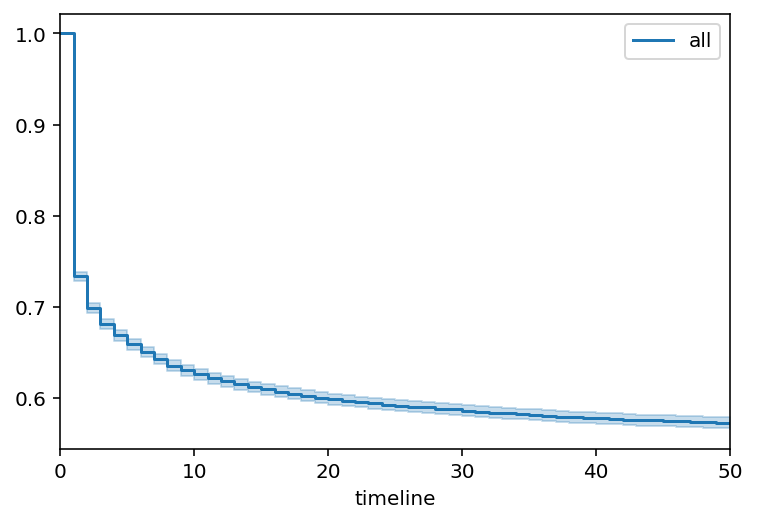

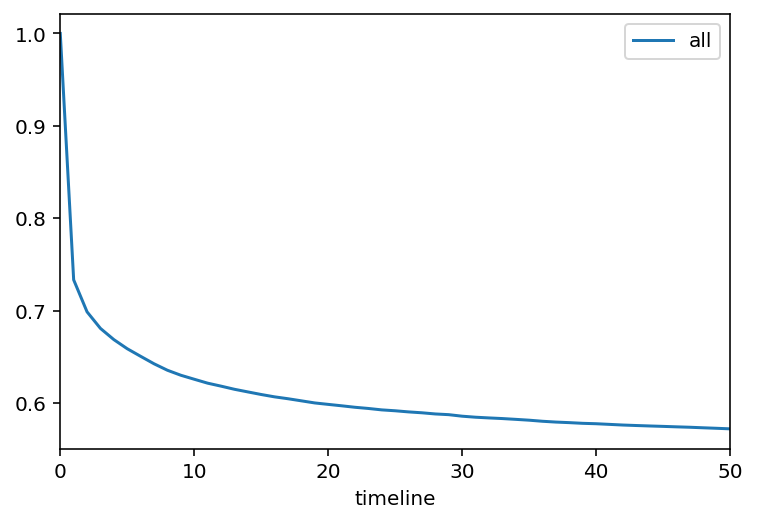

In [13]:
# 全部数据中，时间太长了，实际中只关注前面的 50 天，所以这里限制在前 50 天
t = np.linspace(0, 50, 51)

kmf = KaplanMeierFitter()
kmf.fit(df['duration'],
        event_observed=df['have_bought'],
        label='all',
        timeline=t)

# 注意，这里有明显的阶梯，因为时间窗口小的缘故；
kmf.plot()

# 如果希望还是平滑曲线，使用内部的 survial_function_.plot()
kmf.survival_function_.plot()

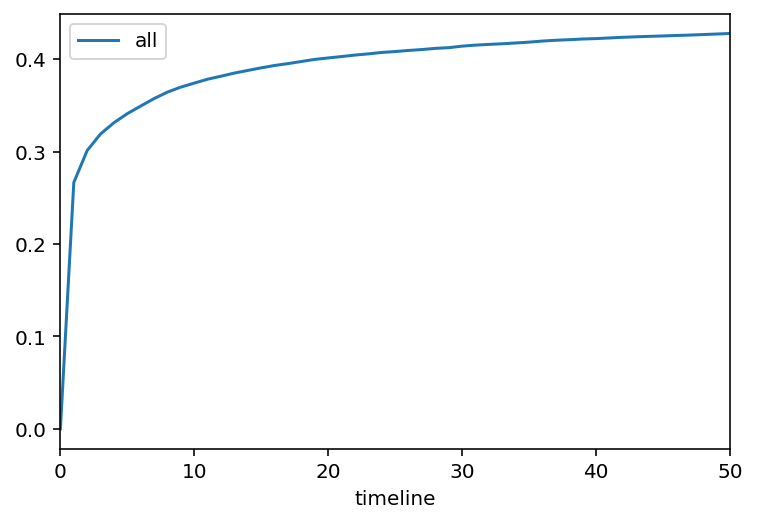

In [11]:
# 业务上，死亡代表产生了购买行为，也即：留存下来的客户，所以，正向看
(1 - kmf.survival_function_).plot()

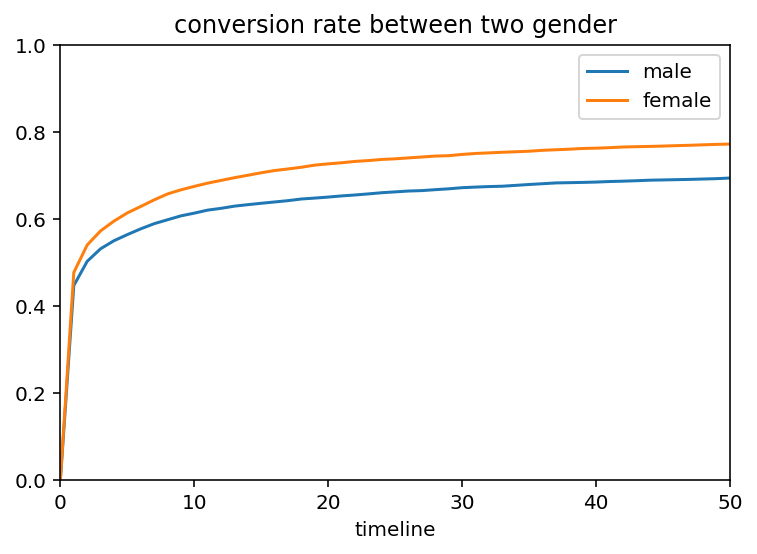

In [18]:
# 上述 survial 分析是全集，现在区分男女，也即：一张图上，画两条线
ax = plt.subplot(111)

t = np.linspace(0, 50, 51)
kmf.fit(df[df['sex'] == '男']['duration'],
        event_observed=df[df['sex'] == '男']['have_bought'],
        timeline=t,
        label="male")
ax = (1 - kmf.survival_function_).plot(ax=ax)

kmf.fit(df[df['sex'] == '女']['duration'],
        event_observed=df[df['sex'] == '女']['have_bought'],
        timeline=t,
        label="female")
ax = (1 - kmf.survival_function_).plot(ax=ax)

plt.ylim(0, 1)
plt.title("conversion rate between two gender")

In [25]:
# 图形上有差异，那么这差异是否显著
r = logrank_test(durations_A=df[df['sex'] == '男']['duration'],
             event_observed_A=df[df['sex'] == '男']['have_bought'],
             durations_B=df[df['sex'] == '女']['duration'],
             event_observed_B=df[df['sex'] == '女']['have_bought'])

r.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
          87.49 <0.005     66.68


<lifelines.NelsonAalenFitter: fitted with 26563 observations, 14904 censored>

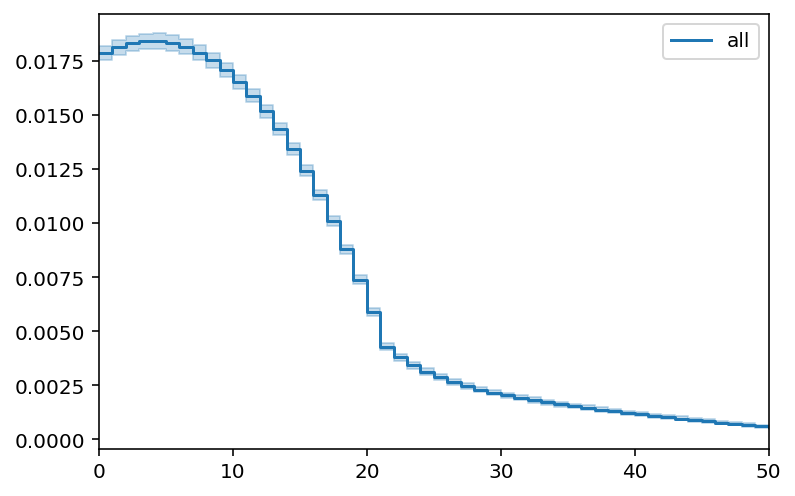

In [26]:
# hazard 变化率曲线，全集
naf = NelsonAalenFitter()
naf.fit(df['duration'],
        event_observed=df['have_bought'],
        timeline=t,
        label='all')
naf.plot_hazard(bandwidth=20)

<lifelines.NelsonAalenFitter: fitted with 5526 observations, 1573 censored>

<lifelines.NelsonAalenFitter: fitted with 9691 observations, 1985 censored>

Text(0.5, 1.0, 'hazard function (convertion diff rate) between two gender')

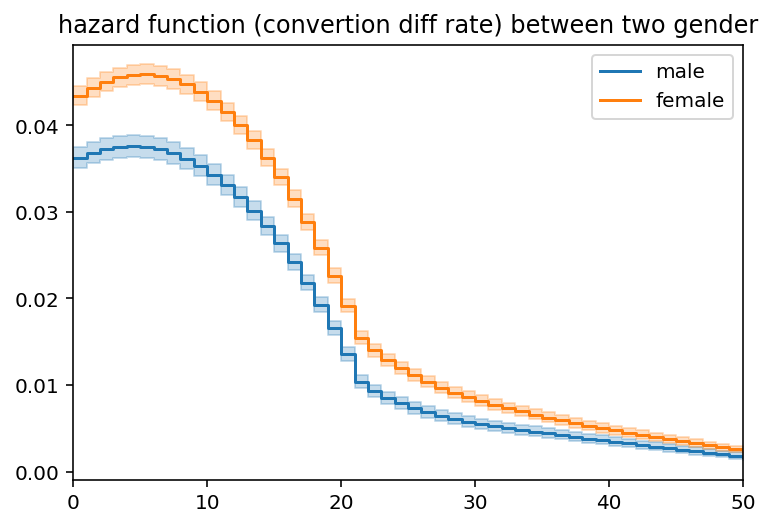

In [28]:
# 细分到男女
ax = plt.subplot(111)

t = np.linspace(0, 50, 51)
naf.fit(df[df['sex'] == '男']['duration'],
        event_observed=df[df['sex'] == '男']['have_bought'],
        timeline=t,
        label="male")
ax = naf.plot_hazard(bandwidth=20, ax=ax)

naf.fit(df[df['sex'] == '女']['duration'],
        event_observed=df[df['sex'] == '女']['have_bought'],
        timeline=t,
        label="female")
ax = naf.plot_hazard(bandwidth=20, ax=ax)

plt.title("hazard function (convertion diff rate) between two gender")

In [30]:
# 只使用 birth_year 不为空的数据
cph_df = df[~pd.isnull(df['birth_year'])][[
    'birth_year', 'duration', 'have_bought', 'sex'
]]

# recode
cph_df['sex'] = cph_df['sex'].apply(lambda x: 1 if x == '男' else 0)
cph_df['birth_year'] = cph_df['birth_year'] // 10 * 10
cph_df.shape

cph_df.head()

(13923, 4)

,birth_year,duration,have_bought,sex
0,1990.0,0.004052,True,0
1,1980.0,0.021231,True,1
3,1970.0,212.551556,False,0
4,1990.0,0.006316,True,0
6,1990.0,1.728810,True,1


In [31]:
# 拆分成 训练集，测试集
cph_train_df, cph_test_df = cph_df.iloc[0:10000, :], cph_df.iloc[10000:, :]

<lifelines.KaplanMeierFitter: fitted with 3635 observations, 1025 censored>

<lifelines.KaplanMeierFitter: fitted with 6365 observations, 1292 censored>

/Users/ygzheng/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


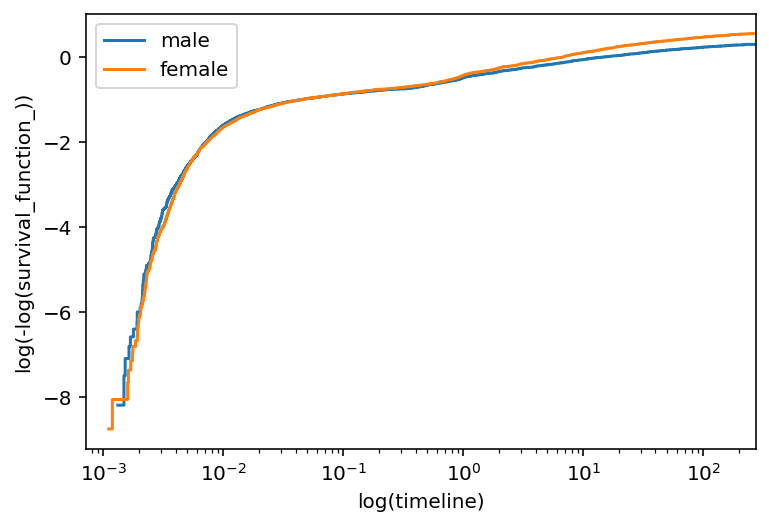

In [32]:
# 使用训练集
kmf0 = KaplanMeierFitter()
kmf0.fit(cph_train_df[cph_train_df['sex'] == 1]['duration'],
         event_observed=cph_train_df[cph_train_df['sex'] == 1]['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_train_df[cph_train_df['sex'] == 0]['duration'],
         event_observed=cph_train_df[cph_train_df['sex'] == 0]['have_bought'])

# 之前是画 survial curve，现在是 loglogs
fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['male', 'female'])

plt.show()

<lifelines.KaplanMeierFitter: fitted with 1054 observations, 194 censored>

<lifelines.KaplanMeierFitter: fitted with 1673 observations, 351 censored>

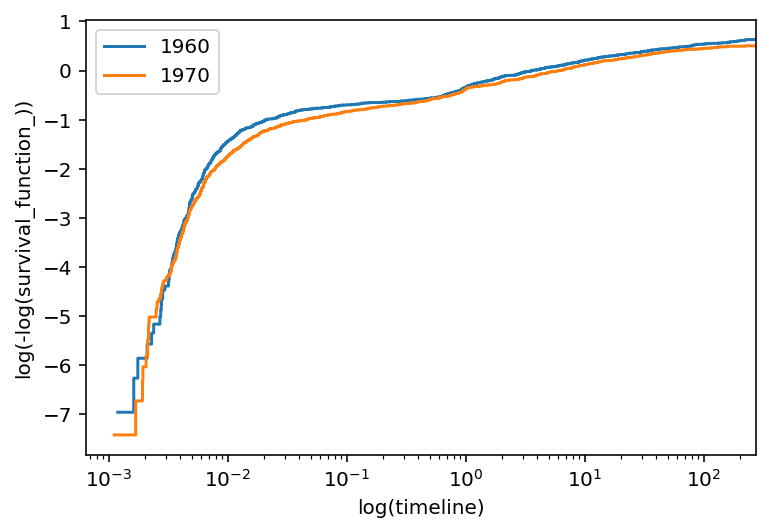

In [33]:
# 上面是细分 男女，现在按照年龄分 60-70，70-80
kmf0 = KaplanMeierFitter()
kmf0.fit(cph_train_df[((cph_train_df['birth_year'] >= 1960) &
                       (cph_train_df['birth_year'] < 1970))]['duration'],
         event_observed=cph_train_df[(
             (cph_train_df['birth_year'] >= 1960) &
             (cph_train_df['birth_year'] < 1970))]['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_train_df[((cph_train_df['birth_year'] >= 1970) &
                       (cph_train_df['birth_year'] < 1980))]['duration'],
         event_observed=cph_train_df[(
             (cph_train_df['birth_year'] >= 1970) &
             (cph_train_df['birth_year'] < 1980))]['have_bought'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['1960', '1970'])

plt.show()

In [34]:
# cox proportion model, 多变量回归
# need waiting for a long while
cph = CoxPHFitter()
cph.fit(cph_train_df, duration_col='duration', event_col='have_bought', show_progress=True)

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -66146.45940, newton_decrement = 0.00000, seconds_since_start = 1.7Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 10000 observations, 2317 censored>

In [35]:
cph.print_summary()
# 这里 birth_year, sex 是因为 cph_train_df 中，除了 duration 和 event 外，就是这两列

<lifelines.CoxPHFitter: fitted with 10000 observations, 2317 censored>
      duration col = 'duration'
         event col = 'have_bought'
number of subjects = 10000
  number of events = 7683
partial log-likelihood = -66146.46
  time fit was run = 2019-09-10 07:13:20 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
birth_year -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
sex        -0.17      0.85      0.02           -0.21           -0.12                0.81                0.89

               z      p  -log2(p)
birth_year -8.79 <0.005     59.27
sex        -6.95 <0.005     37.99
---
Concordance = 0.53
Log-likelihood ratio test = 124.89 on 2 df, -log2(p)=90.09


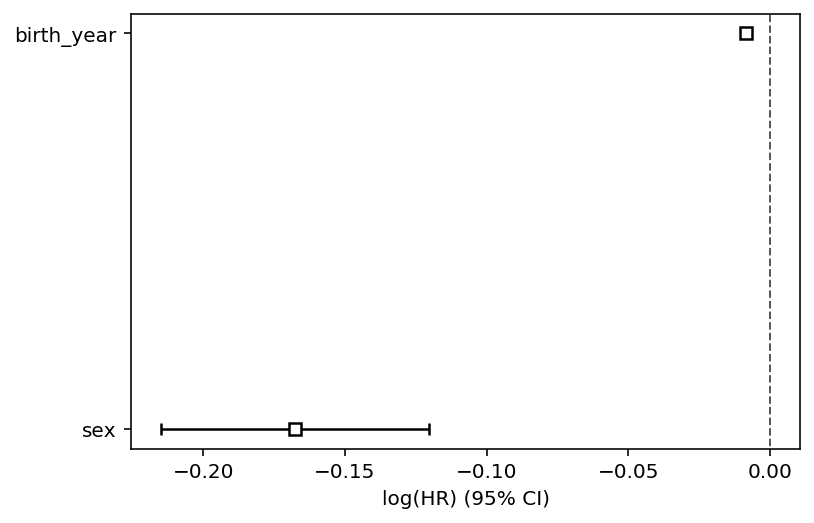

In [36]:
cph.plot()

/Users/ygzheng/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<lifelines.KaplanMeierFitter: fitted with 3923 observations, 942 censored>

<lifelines.KaplanMeierFitter: fitted with 3923 observations, 942 censored>

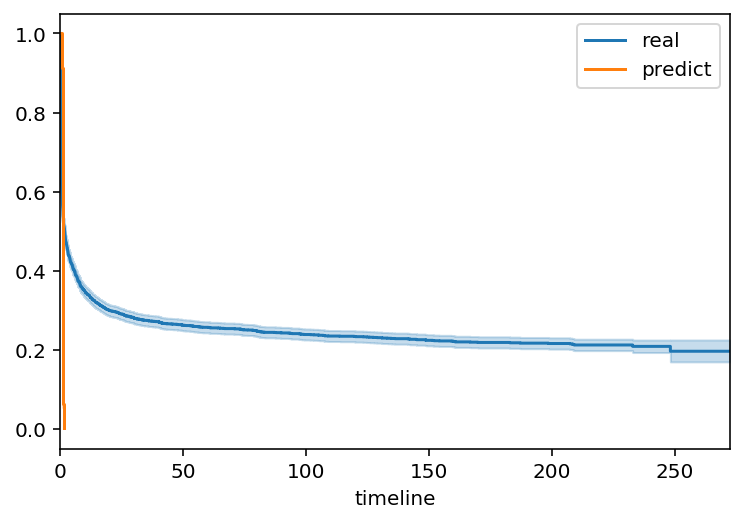

In [37]:
# 使用 cox model 进行预测
# 输入：cox model 中的 coef 对应的变量
# 输入：时间长度

cph_test_df_predict = cph_test_df[['birth_year', 'sex']]
cph_test_df['predict_duration'] = cph.predict_partial_hazard(
    cph_test_df_predict)

# 不明白再做模型的意义
kmf0 = KaplanMeierFitter()
kmf0.fit(cph_test_df['duration'], event_observed=cph_test_df['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_test_df['predict_duration'],
         event_observed=cph_test_df['have_bought'])

fig, axes = plt.subplots()
kmf0.plot(ax=axes)
kmf1.plot(ax=axes)

axes.legend(['real', 'predict'])

plt.show()

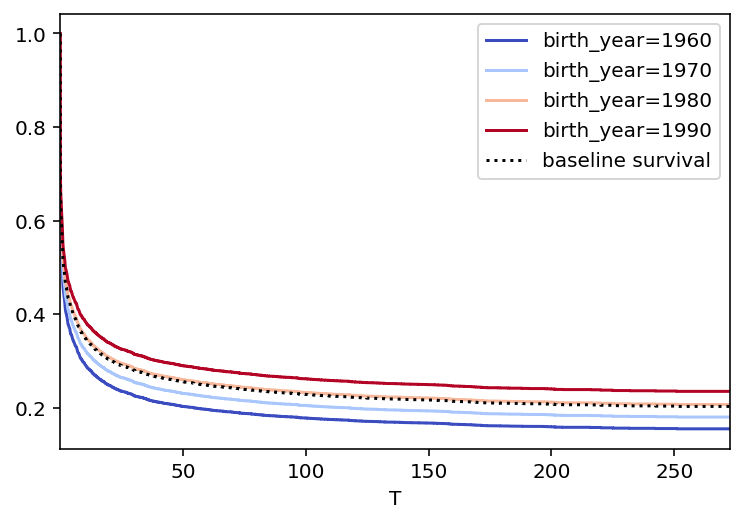

In [43]:
# birth_year 是 cox 中的变量，而且是连续变量，这里通过设置几个值，就实现了分段，并且显示多条曲线
cph.plot_covariate_groups('birth_year', [1960, 1970, 1980, 1990], cmap='coolwarm')

# 这里有 baseline ，对应的是没有任何变量下的 survial curve

<lifelines.KaplanMeierFitter: fitted with 10000 observations, 2317 censored>

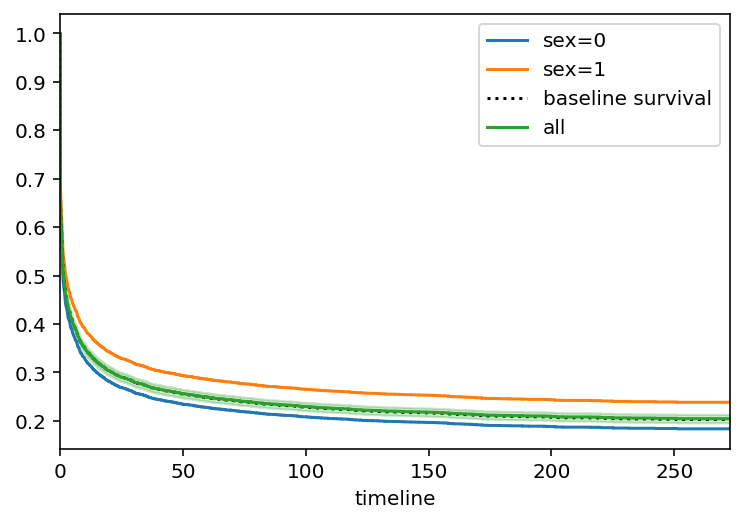

In [46]:
# 0, 1 是数据中的值，对应 女 男
# 女的流失率相对低，也即转化率高
fig, ax = plt.subplots()

cph.plot_covariate_groups('sex', [0, 1], ax = ax)

# plot_covariate_groups 中的 baseline 是否和 不区分 是一样的
# 结论是：baseline 就是不区分时的 survial curve
kmf_base = KaplanMeierFitter()
kmf_base.fit(cph_train_df['duration'], event_observed=cph_train_df['have_bought'], label='all')
kmf_base.plot(ax = ax)